# 1 - Exploração dos dados

## 1.1 - Importando as bibliotecas e carregando a base de dados
Nesta etapa vamos carregar as bibliotecas necessárias, importar a base e exibir os primeiros registros dela


In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, silhouette_score

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, IsolationForest
import numpy as np

df = pd.read_csv("../assets/crop_yield.csv")
df.head()



,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### Entendo a qualidade dos dados
Vamos verificar a estrutura desta base 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


## 1.2 - Normalizando os dados
Convertendo o campo Crop, que representa o tipo de cultivo, para numérico. 

In [3]:
# Aplicando LabelEncoder
encoder = LabelEncoder()
df["Crop"] = encoder.fit_transform(df["Crop"])
df.head()

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,0,2248.92,17.72,83.40,26.01,11560
1,0,1938.42,17.54,82.11,26.11,11253
2,0,2301.54,17.81,82.79,26.24,9456
3,0,2592.35,17.61,85.07,25.56,9321
4,0,2344.72,17.61,84.12,25.76,8800


### Resultado do encode
Desta forma o campo Crop foi convertido para um sequencial onde:
- 0 = Cocoa, beans
- 1 = Oil palm fruit
- 2 = Rice, paddy
- 3 = Rubber, natural

## 1.3 - Dados duplicados
Vamos verificar se existem dados duplicados e remove-los caso existam

In [4]:
# Verificar duplicados
duplicados = df[df.duplicated()]

# Resultado
if duplicados.empty:
    print("✅ Não existem registros duplicados na base.")
else:
    print("⚠️ Existem registros duplicados. Removendo dados!")
    df.drop_duplicates(inplace=True)

✅ Não existem registros duplicados na base.


## 1.4 - Avaliando a importância das features
Em primeiro lugar vamos tentar identificar usando o Algoritmo RandomForestClassifier (algoritimo de arvore de decisão)  a influencia de cada variavel individualmente no resultado final da produção. 

                                Feature  Importance
0                                  Crop    0.360578
1              Precipitation (mm day-1)    0.174480
4           Temperature at 2 Meters (C)    0.156061
3     Relative Humidity at 2 Meters (%)    0.155045
2  Specific Humidity at 2 Meters (g/kg)    0.153836


/var/folders/_m/trnh2xms1vs03wcv1x7k6fs40000gn/T/ipykernel_53420/4072522553.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importances, palette="viridis")


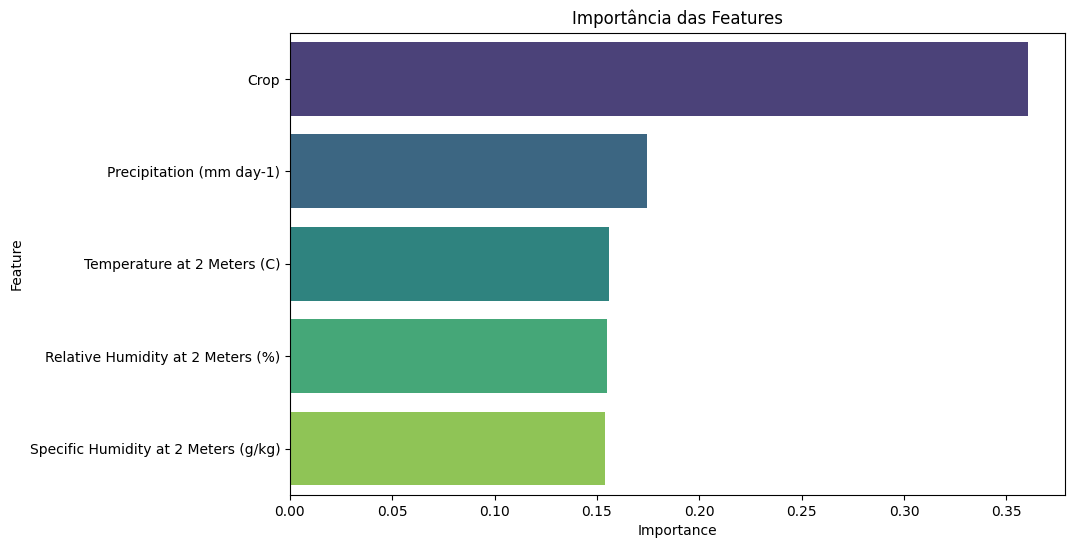

In [5]:
# Separar features e target
X = df.drop(columns=["Yield"])
y = df["Yield"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Treinar modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Obter importâncias
importances = model.feature_importances_
feature_names = X.columns

# Criar DataFrame de importâncias
feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_importances)

# Visualizar em gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_importances, palette="viridis")
plt.title("Importância das Features")
plt.show()

## 1.5 - Comparando a relação entre vas variáveis
Agora vamos comparar a relação entre estas variáveis, e como estes dados estão distribuidos

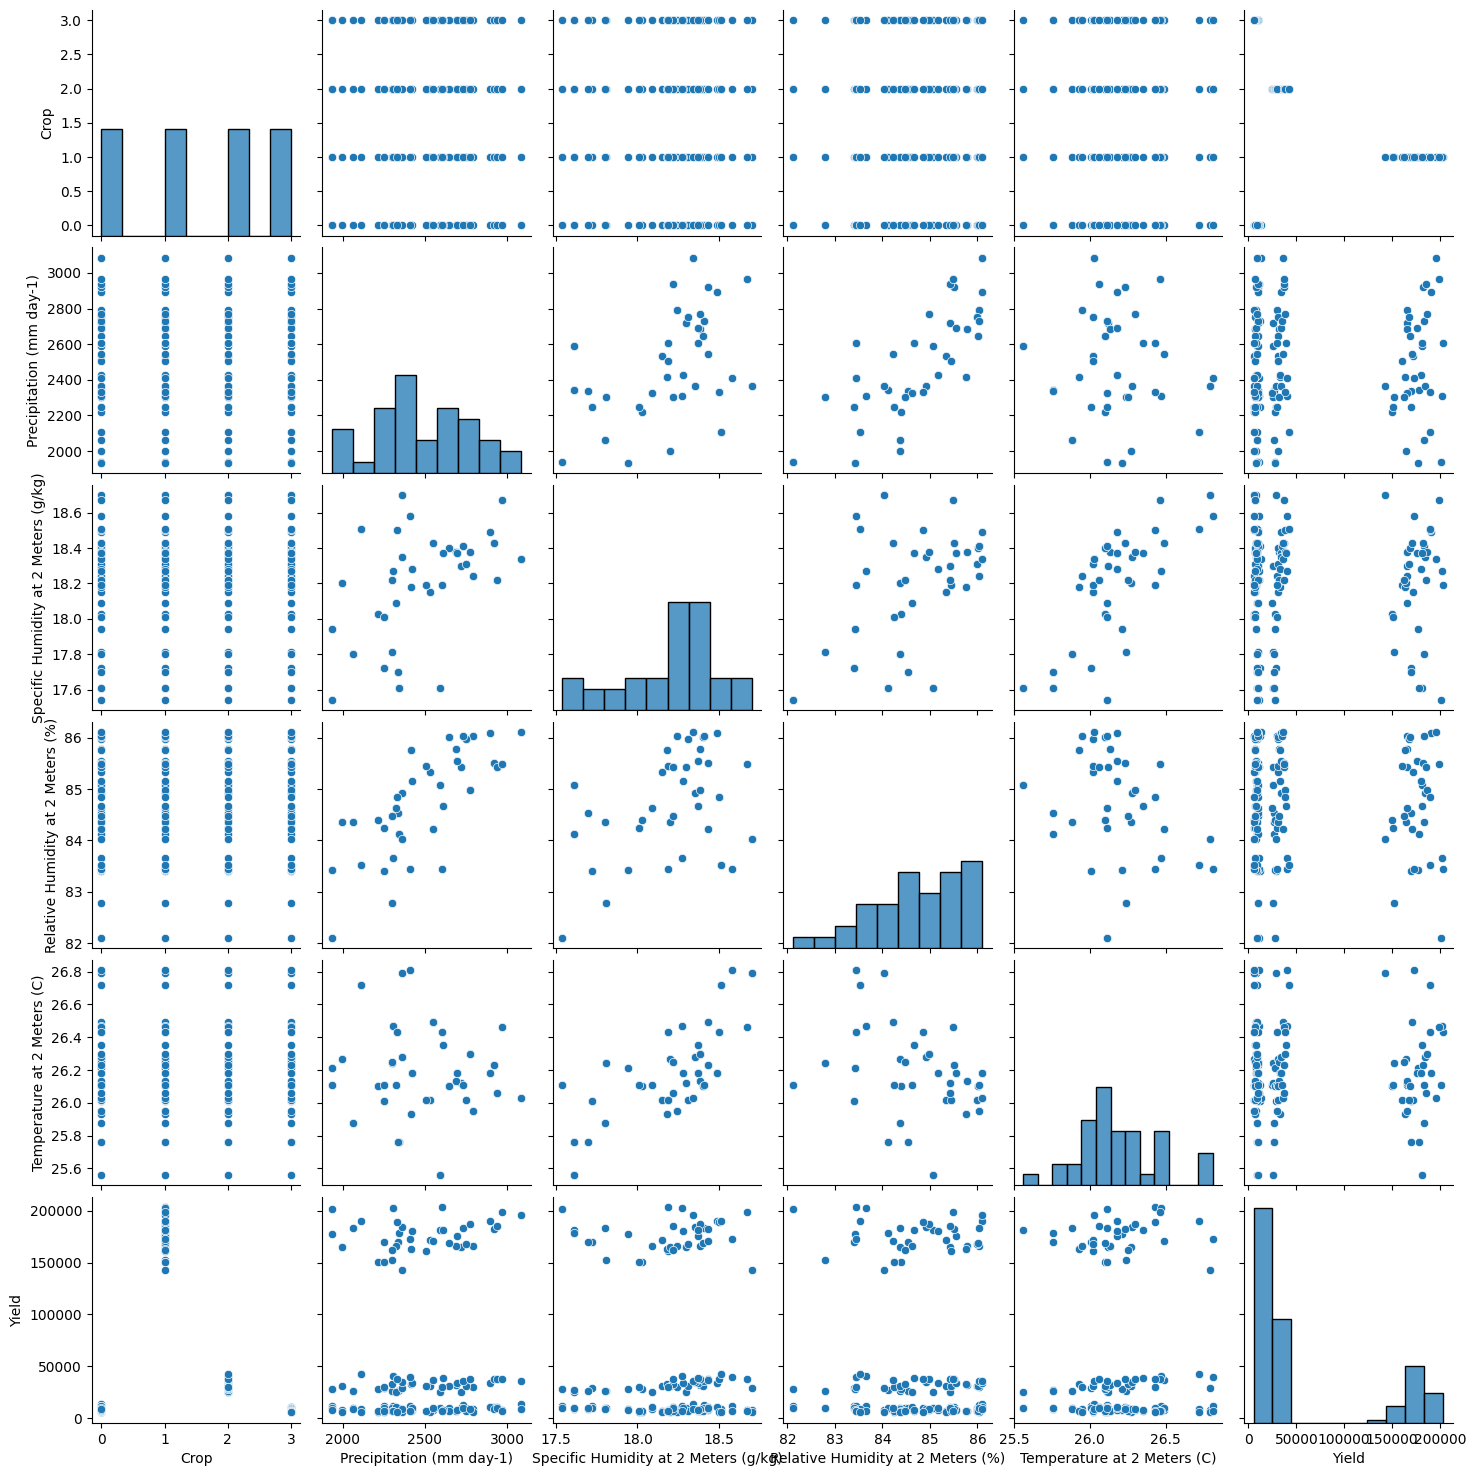

In [6]:
sns.pairplot(df)
plt.show()

Vamos ver numéricamente como estas variáveis se relacionam para o resultado final

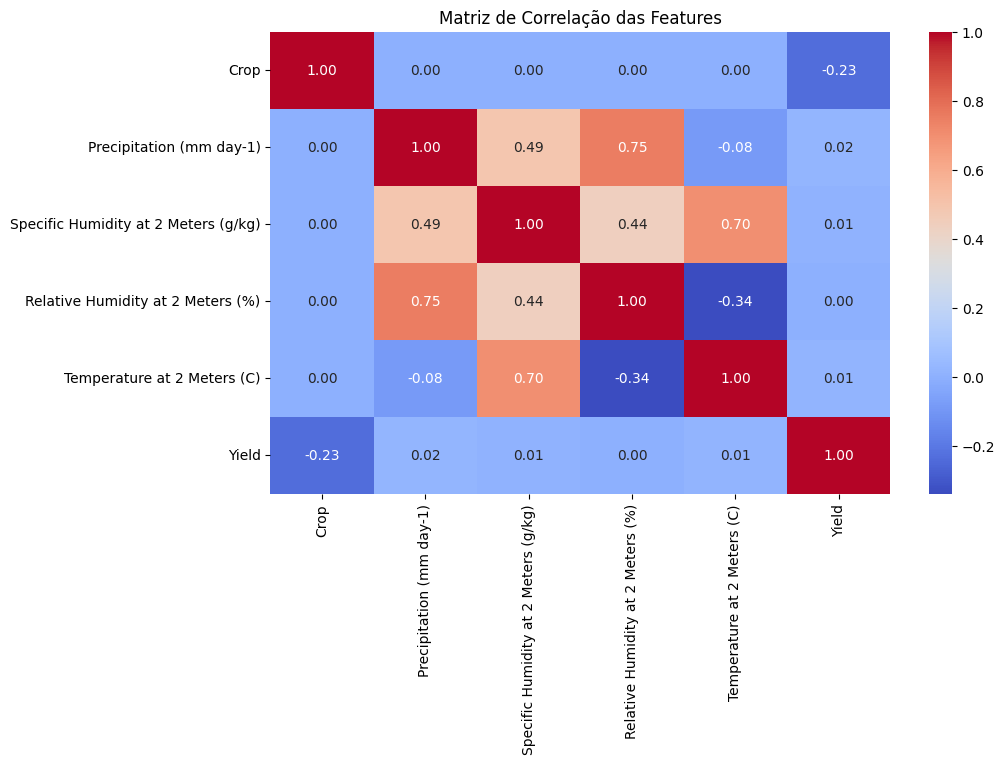

In [7]:
# Matriz de correlação
corr = df.corr()

# Plot com heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Features")
plt.show()

### 1.6 - Removendo Outliers
Para melhor separarmos os clusters, vamos identificar e remover os "pontos fora da curva", conhecidos pelo termo em ingles "ouliers". 
Para isso vamos usar o algoritmo "IsolationFerest" da biblioteca "skylearn" que é recomendado para dados multimensionais como as nossas features climáticas. 

In [8]:
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df.select_dtypes(include=[np.number]))

# Mantém apenas os normais (label = 1)
df = df[outliers == 1]

### Conclusão
Percebemos aqui que o tipo de cultivo e o quanto chove diariamente são fatores mais importantes que contribuem para o resultado da produção

## 2 - Clusterização com modelo não supervisionado
Vamos usar modelos não supervisionados para identificar grupos em comum nestes dados.

### 2.1 - Escolha do modelo
Dado a explocação que fizemos nos dados e as conclusões que chegamos e que nossa missão é encontrar grupos claros e compactos de culturas com base nas condições climáticas entendo que o KMeans é a melhor opção por funcionar bem com datasets menores. O DBScan por exemplo tem melhores resultados com mais exemplos (base de dados maior).

### 2.2 - Normalização dos dados em escalas diferentes
A ideia aqui é preparar os dados para nosso experimento, colocando todos em uma mesma escala. 

In [9]:
# ----------------------------
# Configurações do experimento
# ----------------------------
target_col_for_eval = "Crop"  # usado apenas para avaliação/comparação
random_state = 42

# Selecionar colunas numéricas
num_cols = df.select_dtypes(include=["number", "float64", "int64"]).columns.tolist()

# Remover a coluna categórica 'Crop' das features (se estiver codificada como número em algum contexto)
if target_col_for_eval in num_cols:
    num_cols.remove(target_col_for_eval)

X = df[num_cols].copy()

# ----------------------------
# Padronização
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 2.3 - Analisando a distribuição Hierarquico dos dados com Dendograma

Vamos usar o dendograma para validar visualmente a distribuição dos dados

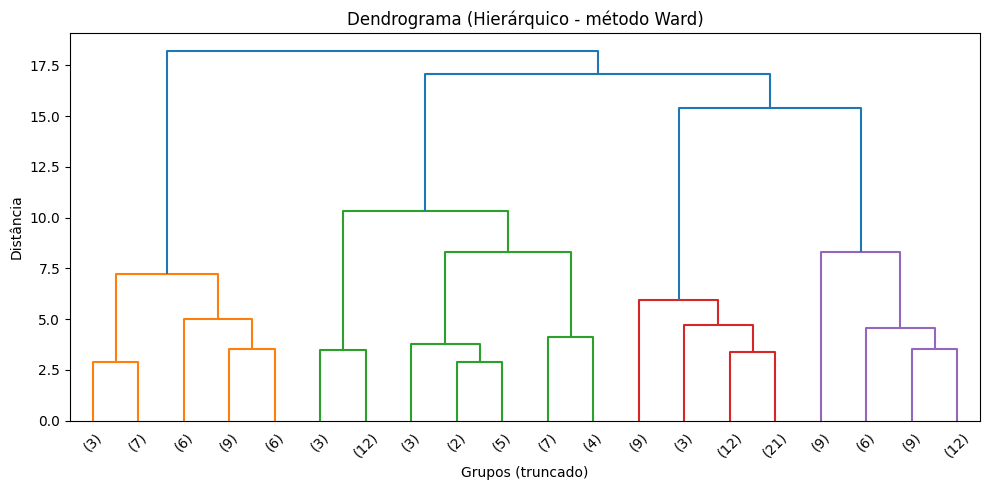

In [10]:
plt.figure(figsize=(10, 5))
Z = linkage(X_scaled, method="ward")
dendrogram(Z, truncate_mode="lastp", p=20, leaf_rotation=45., leaf_font_size=10.)
plt.title("Dendrograma (Hierárquico - método Ward)")
plt.xlabel("Grupos (truncado)")
plt.ylabel("Distância")
plt.tight_layout()
plt.show()

### 2.4 - Método Cotovelo
A ideia é aplicar o método cotovelo para idetnticar o melhor número de cluster para usar com o KMeans.

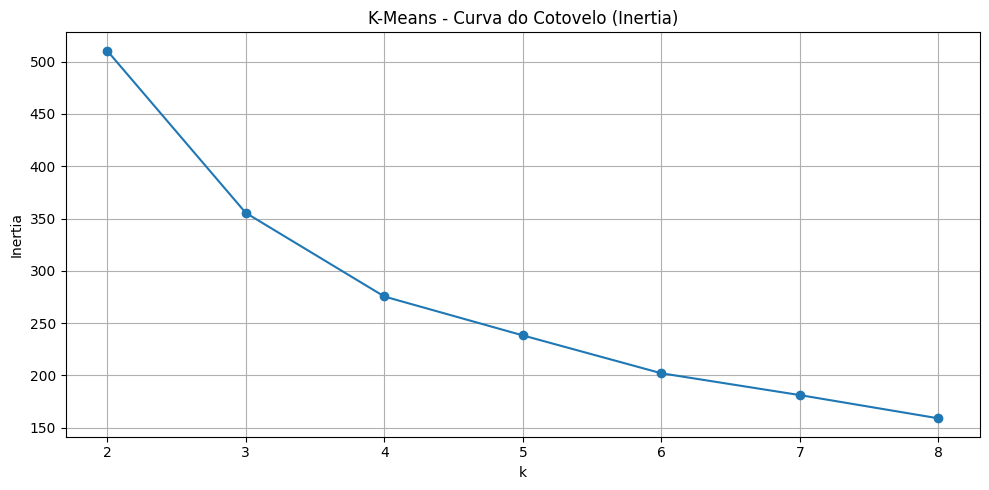

In [11]:
k_range = range(2, 9)

inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels_km = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 5))

# Elbow
plt.plot(list(k_range), inertias, marker="o")
plt.title("K-Means - Curva do Cotovelo (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.tight_layout()
plt.show()


### 2.5 - Treinamento e executando o modelo KMeans
Vamos usar o valor 3 identificado pelo demografico, também corroborado pelo método de cotovelo que mostra uma queda na intensidade de descida a partir do mesmo número. O valor 3 será usado como o número ideal para o número de clusters e medir o resultado com o silhoutte score da uma nota ao processo de clusterização pela coesão e separação. 
Nesta medição quanto menor a distancia média entre os pontos maior é a coesão (e melhor é este cluster)
Quanto maior a distância entre os clusters diferentes, melhor terá sido a separação entre eles. 

Vamos exibir esta distribuição em 2D, para isso vamos usar a tecnica de PCA para reduzir a dimensionalidade. 

Silhouette (K-Means, k=3): 0.3448


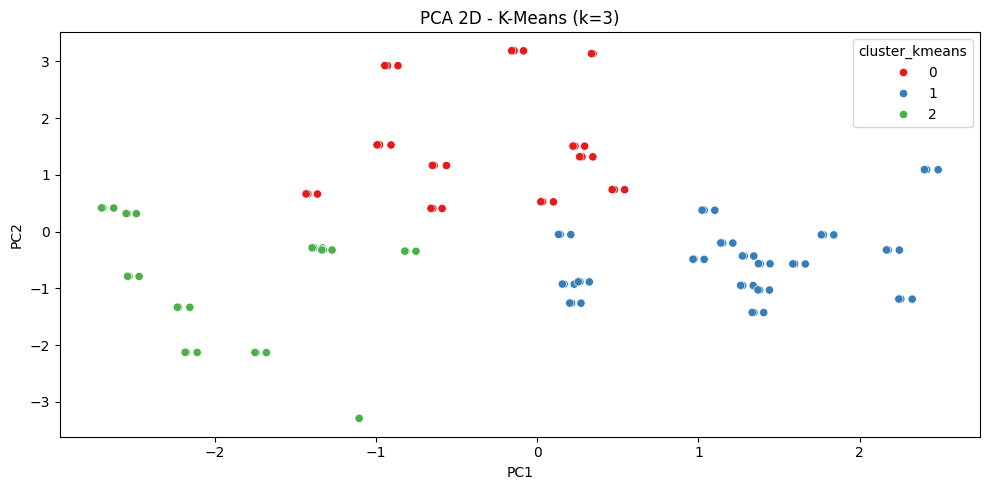

In [12]:
best_k = 3 # recuperado do grafico de cotovelo
kmeans = KMeans(n_clusters=best_k, random_state=random_state, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, labels_kmeans)

print(f"Silhouette (K-Means, k={best_k}): {sil_kmeans:.4f}")

pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["cluster_kmeans"] = labels_kmeans
if target_col_for_eval in df.columns:
    df_plot[target_col_for_eval] = df[target_col_for_eval].values

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="cluster_kmeans", palette="Set1")
plt.title(f"PCA 2D - K-Means (k={best_k})")
plt.tight_layout()
plt.show()

## 3 - Treinar 5 modelos supervisioados

### 3.1 - Escolha e configuração dos modelos
Escolhemos os 5 modelos abaixo para este experimento:
- LinearRegression
- RidgeCV
- SVR_RBF
- RandomForest
- GradientBoosting


In [13]:
# instanciando os algoritmos em um array
# já com seus parametros 
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5),
    "SVR_RBF": SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# Pré-processamento:
# - OneHot para 'Crop'
# - Scale para numéricas (necessário para SVR/Linear/Ridge; inócuo para árvores)

target = "Yield"
categorical = ["Crop"]  # categóricas
numeric = [c for c in df.columns if c not in categorical + [target]]

X = df[categorical + numeric].copy()
y = df[target].copy()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", StandardScaler(), numeric),
    ],
    remainder="drop",
)

pipelines = {name: Pipeline([("prep", preprocess), ("model", mdl)])
             for name, mdl in models.items()}

### 3.2 - Treinar o modelo
Vamos primeiro separar parte desta base para treino e parte para testar o resulatdo depois da predição. 
- Lembrando que a coluna que vamos predizer é a Yield (que é a produção da safra)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred)

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    # Cross-val (R2, MAE, RMSE)
    r2_cv = cross_val_score(pipe, X, y, cv=kf, scoring="r2")
    mae_cv = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error")
    rmse_cv = np.sqrt(-cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error"))

    # Fit + teste
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = {
        "model": name,
        "r2_cv_mean": r2_cv.mean(),
        "mae_cv_mean": mae_cv.mean(),
        "rmse_cv_mean": rmse_cv.mean(),
        "r2_test": r2_score(y_test, y_pred),
        "mae_test": mean_absolute_error(y_test, y_pred),
        "rmse_test": rmse(y_test, y_pred),
    }
    results.append(res)

/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/seberino/Library/Python/3.9/lib/python/site-packages/sklearn/util

### 3.3 - Exibindo as métricas comparativas
Dado que treinamos e testamos os dados com os 5 modelos, vamos exibir as métricas de performance de cada modelo. 

In [15]:
# Tabela comparativa
df_metrics = pd.DataFrame(results).sort_values(by="rmse_test")
print("\n=== MÉTRICAS (ordenado por RMSE de teste) ===")
print(df_metrics.to_string(index=False))


=== MÉTRICAS (ordenado por RMSE de teste) ===
           model  r2_cv_mean  mae_cv_mean  rmse_cv_mean   r2_test     mae_test    rmse_test
GradientBoosting    0.990471  4074.509696   6669.816813  0.990821  3416.285873 3.801728e+07
    RandomForest    0.991159  3900.009176   6430.223537  0.990543  3279.507162 3.916712e+07
LinearRegression    0.989619  4777.033595   6998.272576  0.988212  4325.145013 4.882071e+07
         RidgeCV    0.989607  4750.102077   7001.797736  0.988153  4332.691887 4.906684e+07
         SVR_RBF   -0.294020 48424.710987  78164.484233 -0.066992 40691.799154 4.419078e+09
